# Q1

In [ ]:
import wandb
wandb.login()

True

wandb: Network error (ConnectTimeout), entering retry loop.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


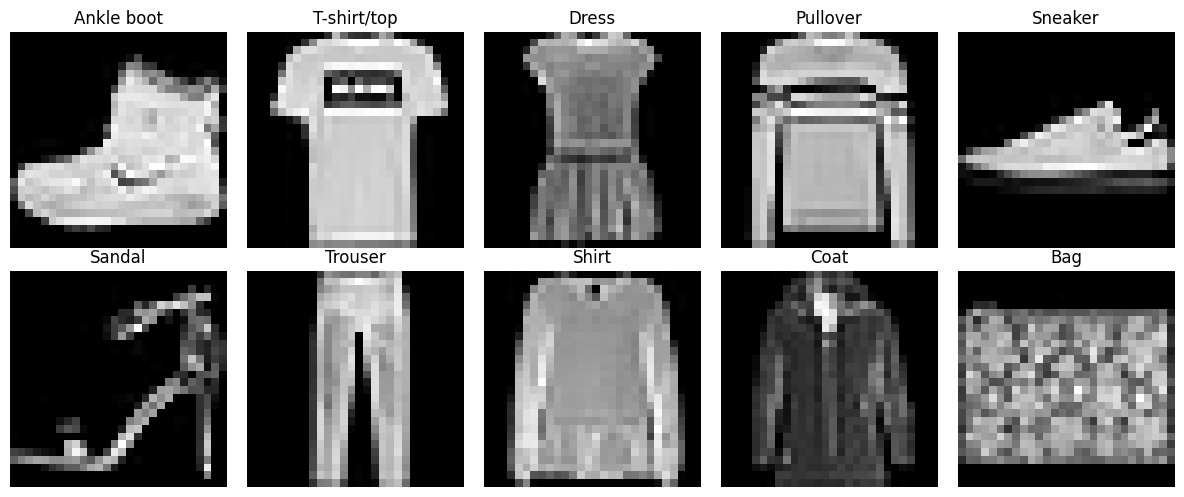

In [ ]:
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names for the Fashion-MNIST labels
CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Function to plot one sample per class
def plot_one_sample_per_class(X, y, class_names):
    plotted_classes = set()
    plt.figure(figsize=(12, 5))
    count = 0

    for i in range(len(X)):
        label = y[i]
        if label not in plotted_classes:
            plotted_classes.add(label)
            count += 1
            plt.subplot(2, 5, count)
            # Use a grayscale colormap for clarity, but you can use others (e.g. 'BrBG', 'Blues')
            plt.imshow(X[i], cmap="gray")  
            plt.title(class_names[label])
            plt.axis("off")

            if count == 10:  # We have 10 classes total
                break

    plt.tight_layout()
    plt.show()

# 1. Plot one sample per class (just a local Matplotlib plot)
plot_one_sample_per_class(X_train, y_train, CLASS_NAMES)

# 2. Initialize a Weights & Biases run
wandb.init(project="DL_Assignment1", name="question_1466")

# Prepare two sets of 18 images each for logging
set1_images = []
set2_images = []

for i in range(18):
    set1_images.append(
        wandb.Image(
            X_train[i], 
            caption=f"{CLASS_NAMES[y_train[i]]} (idx={i})"
        )
    )

for i in range(18, 36):
    set2_images.append(
        wandb.Image(
            X_train[i], 
            caption=f"{CLASS_NAMES[y_train[i]]} (idx={i})"
        )
    )

# 3. Log these sets to W&B in a single step
wandb.log({"Set 1": set1_images, "Set 2": set2_images})

# 4. Finish the run
wandb.finish()


In [21]:
import wandb
import numpy as np
from keras.datasets import fashion_mnist

# Initialize wandb run
wandb.init(project="DL_Assignment1", name="question_2")

# -----------------------
# Data Loading & Preprocessing
# -----------------------
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images to 784-dimensional vectors and normalize pixel values to [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test  = X_test.reshape(-1, 28*28) / 255.0

# One-hot encoding for labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train, 10)
y_test_onehot  = one_hot(y_test, 10)

# -----------------------
# Neural Network Definition
# -----------------------
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.1):
        """
        layer_sizes: List of integers defining the architecture.
                     e.g., [784, 128, 64, 10] represents:
                     Input (784) -> Hidden (128) -> Hidden (64) -> Output (10)
        learning_rate: Learning rate for gradient descent.
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        for i in range(self.num_layers - 1):
            # He initialization for layers with ReLU activation
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        # Use numerical stability trick by subtracting max value in each row
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass through the network.
        Returns:
            A: the output probability distribution from the softmax layer.
        Also stores intermediate linear combinations (zs) and activations for backprop.
        """
        self.zs = []          # Linear combinations at each layer
        self.activations = [X]  # Store activations, starting with input
        
        A = X
        # Hidden layers with ReLU activation
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        
        # Output layer: linear transformation followed by softmax activation
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    
    def compute_loss(self, Y_pred, Y_true):
        """
        Computes cross-entropy loss.
        """
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    
    def backward(self, Y_pred, Y_true):
        """
        Backpropagation to compute gradients and update weights and biases.
        """
        m = Y_true.shape[0]
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer delta (softmax + cross-entropy derivative)
        delta = (Y_pred - Y_true) / m  
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Propagate backwards through the hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.relu_derivative(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # Update weights and biases with gradient descent
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i]  -= self.learning_rate * db[i]
    
    def predict(self, X):
        Y_pred = self.forward(X)
        return np.argmax(Y_pred, axis=1)

# -----------------------
# Network Configuration & Training
# -----------------------
# Define network architecture; change the list below to modify hidden layers/neuron counts.
layer_sizes = [784, 128, 64, 10]
nn = NeuralNetwork(layer_sizes, learning_rate=0.1)

# Training parameters
num_epochs = 10
batch_size = 64
num_batches = X_train.shape[0] // batch_size

for epoch in range(num_epochs):
    # Shuffle training data
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    y_train_onehot_shuffled = y_train_onehot[perm]
    
    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_onehot_shuffled[start:end]
        
        # Forward pass
        Y_pred = nn.forward(X_batch)
        loss = nn.compute_loss(Y_pred, y_batch)
        epoch_loss += loss
        
        # Backward pass and parameter update
        nn.backward(Y_pred, y_batch)
    
    avg_loss = epoch_loss / num_batches
    train_predictions = nn.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    wandb.log({"epoch": epoch+1, "loss": avg_loss, "accuracy": train_accuracy})

# Evaluate on test set
test_predictions = nn.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
wandb.log({"test_accuracy": test_accuracy})

# -----------------------
# Output a Probability Distribution for a Sample Test Image
# -----------------------
# Define class names for clarity
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Choose a sample test image (here, the first image)
sample_idx = 34
sample_input = X_test[sample_idx:sample_idx+1]  # Keep the batch dimension
prob_distribution = nn.forward(sample_input)

print("\nProbability distribution for the first test image:")
for i, prob in enumerate(prob_distribution[0]):
    print(f"{CLASS_NAMES[i]}: {prob:.4f}")

# Log the sample probability distribution as a wandb table for visualization
table_data = [[CLASS_NAMES[i], prob_distribution[0][i]] for i in range(10)]
wandb.log({"sample_prob_distribution": wandb.Table(data=table_data, columns=["Class", "Probability"])})

# Finish wandb run
wandb.finish()


Epoch 1/10 - Loss: 0.5689 - Accuracy: 0.8469
Epoch 2/10 - Loss: 0.4079 - Accuracy: 0.8626
Epoch 3/10 - Loss: 0.3624 - Accuracy: 0.8549
Epoch 4/10 - Loss: 0.3395 - Accuracy: 0.8762
Epoch 5/10 - Loss: 0.3195 - Accuracy: 0.8903
Epoch 6/10 - Loss: 0.3043 - Accuracy: 0.8837
Epoch 7/10 - Loss: 0.2926 - Accuracy: 0.8948
Epoch 8/10 - Loss: 0.2811 - Accuracy: 0.9048
Epoch 9/10 - Loss: 0.2730 - Accuracy: 0.9017
Epoch 10/10 - Loss: 0.2645 - Accuracy: 0.9080
Test Accuracy: 0.8796

Probability distribution for the first test image:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0000
Bag: 1.0000
Ankle boot: 0.0000


accuracy,▁▃▂▄▆▅▆█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
accuracy,0.90798
epoch,10
loss,0.26449
test_accuracy,0.8796


# Q2

In [38]:
import wandb
wandb.login()

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


In [39]:
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images to 784-dimensional vectors and normalize pixel values to [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test  = X_test.reshape(-1, 28*28) / 255.0

# One-hot encoding for labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train, 10)
y_test_onehot  = one_hot(y_test, 10)


In [40]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.1):
        """
        layer_sizes: List of integers defining the architecture.
                     e.g., [784, 128, 64, 10] represents:
                     Input (784) -> Hidden (128) -> Hidden (64) -> Output (10)
        learning_rate: Learning rate for gradient descent.
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        for i in range(self.num_layers - 1):
            # He initialization for layers with ReLU activation
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        # Numerical stability: subtract max from each row
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass through the network.
        Returns:
            A: the output probability distribution from the softmax layer.
        Also stores intermediate values for backpropagation.
        """
        self.zs = []          # Linear combinations
        self.activations = [X]  # List of activations, starting with input
        
        A = X
        # Forward pass for hidden layers using ReLU activation
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        
        # Output layer: linear combination then softmax activation
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    
    def compute_loss(self, Y_pred, Y_true):
        """
        Computes cross-entropy loss.
        """
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    
    def backward(self, Y_pred, Y_true):
        """
        Backpropagation: computes gradients and updates parameters.
        """
        m = Y_true.shape[0]
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer delta: derivative of softmax with cross-entropy loss
        delta = (Y_pred - Y_true) / m  
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.relu_derivative(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # Update parameters using gradient descent
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i]  -= self.learning_rate * db[i]
    
    def predict(self, X):
        Y_pred = self.forward(X)
        return np.argmax(Y_pred, axis=1)


In [41]:
# Initialize a wandb run
wandb.init(project="DL_Assignment1", name="question_2_notebook")

# Define network architecture; adjust the hidden layers/neuron counts as desired.
layer_sizes = [784, 128, 64, 10]
nn = NeuralNetwork(layer_sizes, learning_rate=0.1)

# Training parameters
num_epochs = 10
batch_size = 64
num_batches = X_train.shape[0] // batch_size

for epoch in range(num_epochs):
    # Shuffle training data at the beginning of each epoch
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    y_train_onehot_shuffled = y_train_onehot[perm]
    
    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_onehot_shuffled[start:end]
        
        # Forward pass
        Y_pred = nn.forward(X_batch)
        loss = nn.compute_loss(Y_pred, y_batch)
        epoch_loss += loss
        
        # Backward pass and parameter update
        nn.backward(Y_pred, y_batch)
    
    avg_loss = epoch_loss / num_batches
    train_predictions = nn.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    wandb.log({"epoch": epoch+1, "loss": avg_loss, "accuracy": train_accuracy})

# Evaluate on the test set
test_predictions = nn.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
wandb.log({"test_accuracy": test_accuracy})


Epoch 1/10 - Loss: 0.5750 - Accuracy: 0.8476
Epoch 2/10 - Loss: 0.4082 - Accuracy: 0.8545
Epoch 3/10 - Loss: 0.3677 - Accuracy: 0.8673
Epoch 4/10 - Loss: 0.3432 - Accuracy: 0.8862
Epoch 5/10 - Loss: 0.3224 - Accuracy: 0.8833
Epoch 6/10 - Loss: 0.3085 - Accuracy: 0.8908
Epoch 7/10 - Loss: 0.2952 - Accuracy: 0.8996
Epoch 8/10 - Loss: 0.2851 - Accuracy: 0.9037
Epoch 9/10 - Loss: 0.2753 - Accuracy: 0.8976
Epoch 10/10 - Loss: 0.2661 - Accuracy: 0.9009
Test Accuracy: 0.8699



Probability distribution for test image at index 0:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0008
Shirt: 0.0000
Sneaker: 0.0054
Bag: 0.0000
Ankle boot: 0.9938

Probability distribution for test image at index 10:
T-shirt/top: 0.0001
Trouser: 0.0002
Pullover: 0.1042
Dress: 0.0001
Coat: 0.8264
Sandal: 0.0000
Shirt: 0.0689
Sneaker: 0.0000
Bag: 0.0000
Ankle boot: 0.0000

Probability distribution for test image at index 20:
T-shirt/top: 0.1113
Trouser: 0.0009
Pullover: 0.8073
Dress: 0.0068
Coat: 0.0065
Sandal: 0.0000
Shirt: 0.0655
Sneaker: 0.0000
Bag: 0.0015
Ankle boot: 0.0002

Probability distribution for test image at index 30:
T-shirt/top: 0.0000
Trouser: 0.0000
Pullover: 0.0000
Dress: 0.0000
Coat: 0.0000
Sandal: 0.0000
Shirt: 0.0000
Sneaker: 0.0000
Bag: 1.0000
Ankle boot: 0.0000


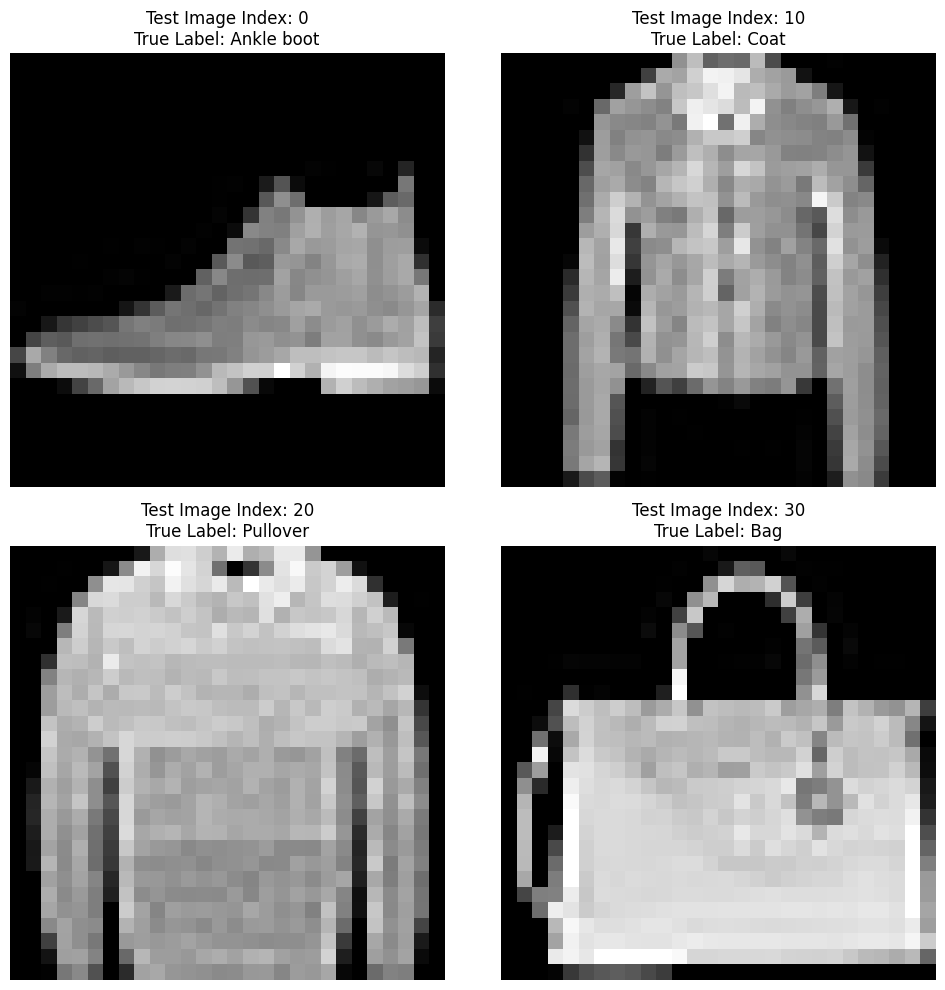

In [42]:
# Define class names for clarity
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# List of sample indices to present
sample_indices = [0, 10, 20, 30]

# Create a wandb Table to log multiple probability distributions
table_rows = []
for sample_idx in sample_indices:
    sample_input = X_test[sample_idx:sample_idx+1]  # Maintain batch dimension
    prob_distribution = nn.forward(sample_input)
    
    print(f"\nProbability distribution for test image at index {sample_idx}:")
    for i, prob in enumerate(prob_distribution[0]):
        print(f"{CLASS_NAMES[i]}: {prob:.4f}")
        table_rows.append([sample_idx, CLASS_NAMES[i], prob])
    
# Log the table to wandb for visualization
prob_table = wandb.Table(data=table_rows, columns=["Sample Index", "Class", "Probability"])
wandb.log({"sample_prob_distributions": prob_table})

# Optionally, you can also visualize one of the sample images along with its predicted label:
import matplotlib.pyplot as plt

sample_indices = [0, 10, 20, 30]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    sample_image = X_test[sample_idx].reshape(28, 28)
    axes[idx].imshow(sample_image, cmap='gray')
    axes[idx].set_title(f"Test Image Index: {sample_idx}\nTrue Label: {CLASS_NAMES[y_test[sample_idx]]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



In [43]:
wandb.finish()


accuracy,▁▂▃▆▅▆▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
accuracy,0.90092
epoch,10
loss,0.26615
test_accuracy,0.8699


# Q3

In [44]:
import wandb
wandb.login()  # Log into Weights & Biases

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


In [45]:
# Load Fashion-MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images (28x28 -> 784) and normalize to [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test  = X_test.reshape(-1, 28*28) / 255.0

# One-hot encoding helper function
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train, 10)
y_test_onehot  = one_hot(y_test, 10)


In [46]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        layer_sizes: list defining the architecture, e.g. [784, 128, 64, 10]
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        # Initialize weights and biases (using He initialization for ReLU)
        for i in range(self.num_layers - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def softmax(self, x):
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """Forward pass: computes activations for each layer."""
        self.zs = []               # Store linear combinations for backpropagation
        self.activations = [X]      # Input is the first activation
        
        A = X
        # Hidden layers with ReLU activation
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.relu(z)
            self.activations.append(A)
        
        # Output layer: linear -> softmax
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        A = self.softmax(z)
        self.activations.append(A)
        return A
    
    def compute_loss(self, Y_pred, Y_true):
        """Compute cross-entropy loss."""
        m = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
        return loss
    
    def backward(self, Y_pred, Y_true):
        """
        Compute gradients for weights and biases via backpropagation.
        Returns:
            dW: list of gradients for weights
            db: list of gradients for biases
        """
        m = Y_true.shape[0]
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Compute gradient at output layer (softmax + cross-entropy)
        delta = (Y_pred - Y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Propagate backwards through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.relu_derivative(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        return dW, db


In [49]:
# SGD Optimizer
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

# Momentum-Based Gradient Descent
class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

# Nesterov Accelerated Gradient Descent
class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            # Save previous velocity
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            # Update velocity
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            # Nesterov update (lookahead)
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

# RMSProp Optimizer
# RMSProp Optimizer
class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

# Adam Optimizer
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1 ** t)
            v_hat_w = self.vw[i] / (1 - self.beta2 ** t)
            m_hat_b = self.mb[i] / (1 - self.beta1 ** t)
            v_hat_b = self.vb[i] / (1 - self.beta2 ** t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

# Nadam Optimizer (Adam with Nesterov momentum) - Corrected Bias Update
class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat = self.mw[i] / (1 - self.beta1 ** t)
            v_hat = self.vw[i] / (1 - self.beta2 ** t)
            m_hat_b = self.mb[i] / (1 - self.beta1 ** t)
            v_hat_b = self.vb[i] / (1 - self.beta2 ** t)
            
            weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * dW[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat) + self.epsilon)
            # Corrected: use v_hat_b for bias update
            biases[i]  -= self.learning_rate * (self.beta1 * m_hat_b + (1 - self.beta1) * db[i] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat_b) + self.epsilon)


In [52]:
# Define a dictionary mapping optimizer names to functions that return a new optimizer instance.
optimizers_dict = {
    "SGD": lambda: SGD(learning_rate=0.01),
    "Momentum": lambda: Momentum(learning_rate=0.01, momentum=0.9),
    "Nesterov": lambda: Nesterov(learning_rate=0.01, momentum=0.9),
    "RMSProp": lambda: RMSProp(learning_rate=0.001, decay_rate=0.9),
    "Adam": lambda: Adam(learning_rate=0.001, beta1=0.9, beta2=0.999),
    "Nadam": lambda: Nadam(learning_rate=0.001, beta1=0.9, beta2=0.999)
}

# Common training parameters
num_epochs = 10
batch_size = 64
num_batches = X_train.shape[0] // batch_size
layer_sizes = [784, 128, 64, 10]

# To store summary results for each optimizer.
results = []

# Loop over each optimizer and run a separate training experiment.
for opt_name, opt_fn in optimizers_dict.items():
    # Initialize a new wandb run for each optimizer.
    run = wandb.init(project="DL_Assignment1", 
                     name=f"question_3_{opt_name}", 
                     reinit=True, 
                     config={
                         "optimizer": opt_name,
                         "num_epochs": num_epochs,
                         "batch_size": batch_size,
                         "layer_sizes": layer_sizes
                     })
    
    # Initialize a new neural network and optimizer instance.
    nn = NeuralNetwork(layer_sizes)
    optimizer = opt_fn()
    
    global_step = 1
    epoch_losses = []
    
    print(f"\nStarting training with optimizer: {opt_name}")
    for epoch in range(num_epochs):
        # Shuffle training data at the start of each epoch.
        perm = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[perm]
        y_train_onehot_shuffled = y_train_onehot[perm]
        
        epoch_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_onehot_shuffled[start:end]
            
            # Forward pass.
            Y_pred = nn.forward(X_batch)
            loss = nn.compute_loss(Y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass: compute gradients.
            dW, db = nn.backward(Y_pred, y_batch)
            
            # Update parameters using the chosen optimizer.
            optimizer.update(nn.weights, nn.biases, dW, db, global_step)
            global_step += 1
        
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Evaluate training accuracy on the entire training set.
        train_predictions = np.argmax(nn.forward(X_train), axis=1)
        train_accuracy = np.mean(train_predictions == y_train)
        
        print(f"{opt_name} | Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        wandb.log({"epoch": epoch+1, "loss": avg_loss, "train_accuracy": train_accuracy})
    
    # Evaluate on the test set.
    test_predictions = np.argmax(nn.forward(X_test), axis=1)
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"{opt_name} | Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"test_accuracy": test_accuracy})
    
    # Save final results for this optimizer.
    results.append({
        "Optimizer": opt_name,
        "Final Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Final Loss": avg_loss
    })
    
    run.finish()



Starting training with optimizer: SGD
SGD | Epoch 1/10 - Loss: 0.8550 - Train Accuracy: 0.8067
SGD | Epoch 2/10 - Loss: 0.5316 - Train Accuracy: 0.8323
SGD | Epoch 3/10 - Loss: 0.4766 - Train Accuracy: 0.8448
SGD | Epoch 4/10 - Loss: 0.4472 - Train Accuracy: 0.8527
SGD | Epoch 5/10 - Loss: 0.4273 - Train Accuracy: 0.8535
SGD | Epoch 6/10 - Loss: 0.4119 - Train Accuracy: 0.8615
SGD | Epoch 7/10 - Loss: 0.3995 - Train Accuracy: 0.8657
SGD | Epoch 8/10 - Loss: 0.3890 - Train Accuracy: 0.8633
SGD | Epoch 9/10 - Loss: 0.3810 - Train Accuracy: 0.8704
SGD | Epoch 10/10 - Loss: 0.3736 - Train Accuracy: 0.8723
SGD | Test Accuracy: 0.8557


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
test_accuracy,▁
train_accuracy,▁▄▅▆▆▇▇▇██
epoch,10
loss,0.37358
test_accuracy,0.8557
train_accuracy,0.87232



Starting training with optimizer: Momentum
Momentum | Epoch 1/10 - Loss: 0.5625 - Train Accuracy: 0.8479
Momentum | Epoch 2/10 - Loss: 0.4038 - Train Accuracy: 0.8681
Momentum | Epoch 3/10 - Loss: 0.3624 - Train Accuracy: 0.8787
Momentum | Epoch 4/10 - Loss: 0.3380 - Train Accuracy: 0.8866
Momentum | Epoch 5/10 - Loss: 0.3166 - Train Accuracy: 0.8914
Momentum | Epoch 6/10 - Loss: 0.3055 - Train Accuracy: 0.8852
Momentum | Epoch 7/10 - Loss: 0.2917 - Train Accuracy: 0.8997
Momentum | Epoch 8/10 - Loss: 0.2810 - Train Accuracy: 0.9021
Momentum | Epoch 9/10 - Loss: 0.2726 - Train Accuracy: 0.9008
Momentum | Epoch 10/10 - Loss: 0.2646 - Train Accuracy: 0.9027
Momentum | Test Accuracy: 0.8715


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▄▅▆▇▆████
epoch,10
loss,0.26463
test_accuracy,0.8715
train_accuracy,0.90273



Starting training with optimizer: Nesterov
Nesterov | Epoch 1/10 - Loss: 0.5350 - Train Accuracy: 0.8490
Nesterov | Epoch 2/10 - Loss: 0.3948 - Train Accuracy: 0.8645
Nesterov | Epoch 3/10 - Loss: 0.3565 - Train Accuracy: 0.8799
Nesterov | Epoch 4/10 - Loss: 0.3351 - Train Accuracy: 0.8844
Nesterov | Epoch 5/10 - Loss: 0.3182 - Train Accuracy: 0.8944
Nesterov | Epoch 6/10 - Loss: 0.3015 - Train Accuracy: 0.8980
Nesterov | Epoch 7/10 - Loss: 0.2911 - Train Accuracy: 0.8969
Nesterov | Epoch 8/10 - Loss: 0.2809 - Train Accuracy: 0.9033
Nesterov | Epoch 9/10 - Loss: 0.2716 - Train Accuracy: 0.9025
Nesterov | Epoch 10/10 - Loss: 0.2618 - Train Accuracy: 0.9085
Nesterov | Test Accuracy: 0.8762


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▃▅▅▆▇▇▇▇█
epoch,10
loss,0.26181
test_accuracy,0.8762
train_accuracy,0.90852



Starting training with optimizer: RMSProp
RMSProp | Epoch 1/10 - Loss: 0.5227 - Train Accuracy: 0.8459
RMSProp | Epoch 2/10 - Loss: 0.3756 - Train Accuracy: 0.8774
RMSProp | Epoch 3/10 - Loss: 0.3388 - Train Accuracy: 0.8746
RMSProp | Epoch 4/10 - Loss: 0.3181 - Train Accuracy: 0.8932
RMSProp | Epoch 5/10 - Loss: 0.3013 - Train Accuracy: 0.8984
RMSProp | Epoch 6/10 - Loss: 0.2891 - Train Accuracy: 0.9022
RMSProp | Epoch 7/10 - Loss: 0.2793 - Train Accuracy: 0.9027
RMSProp | Epoch 8/10 - Loss: 0.2692 - Train Accuracy: 0.9066
RMSProp | Epoch 9/10 - Loss: 0.2639 - Train Accuracy: 0.9083
RMSProp | Epoch 10/10 - Loss: 0.2556 - Train Accuracy: 0.9088
RMSProp | Test Accuracy: 0.8779


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
train_accuracy,▁▅▄▆▇▇▇███
epoch,10
loss,0.25562
test_accuracy,0.8779
train_accuracy,0.90882



Starting training with optimizer: Adam
Adam | Epoch 1/10 - Loss: 0.5056 - Train Accuracy: 0.8521
Adam | Epoch 2/10 - Loss: 0.3718 - Train Accuracy: 0.8765
Adam | Epoch 3/10 - Loss: 0.3386 - Train Accuracy: 0.8843
Adam | Epoch 4/10 - Loss: 0.3124 - Train Accuracy: 0.8931
Adam | Epoch 5/10 - Loss: 0.2971 - Train Accuracy: 0.8989
Adam | Epoch 6/10 - Loss: 0.2819 - Train Accuracy: 0.8975
Adam | Epoch 7/10 - Loss: 0.2690 - Train Accuracy: 0.9004
Adam | Epoch 8/10 - Loss: 0.2612 - Train Accuracy: 0.9086
Adam | Epoch 9/10 - Loss: 0.2502 - Train Accuracy: 0.9090
Adam | Epoch 10/10 - Loss: 0.2417 - Train Accuracy: 0.9183
Adam | Test Accuracy: 0.8837


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▂▂▁▁
test_accuracy,▁
train_accuracy,▁▄▄▅▆▆▆▇▇█
epoch,10
loss,0.24171
test_accuracy,0.8837
train_accuracy,0.91828



Starting training with optimizer: Nadam
Nadam | Epoch 1/10 - Loss: 0.4874 - Train Accuracy: 0.8652
Nadam | Epoch 2/10 - Loss: 0.3652 - Train Accuracy: 0.8776
Nadam | Epoch 3/10 - Loss: 0.3279 - Train Accuracy: 0.8828
Nadam | Epoch 4/10 - Loss: 0.3049 - Train Accuracy: 0.8937
Nadam | Epoch 5/10 - Loss: 0.2882 - Train Accuracy: 0.8978
Nadam | Epoch 6/10 - Loss: 0.2751 - Train Accuracy: 0.9034
Nadam | Epoch 7/10 - Loss: 0.2630 - Train Accuracy: 0.9089
Nadam | Epoch 8/10 - Loss: 0.2516 - Train Accuracy: 0.9115
Nadam | Epoch 9/10 - Loss: 0.2428 - Train Accuracy: 0.9085
Nadam | Epoch 10/10 - Loss: 0.2333 - Train Accuracy: 0.9176
Nadam | Test Accuracy: 0.8828


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
test_accuracy,▁
train_accuracy,▁▃▃▅▅▆▇▇▇█
epoch,10
loss,0.23334
test_accuracy,0.8828
train_accuracy,0.91765


In [ ]:
# Create a wandb Table with the summary results.
summary_table = wandb.Table(columns=["Optimizer", "Final Train Accuracy", "Test Accuracy", "Final Loss"])
for res in results:
    summary_table.add_data(res["Optimizer"], res["Final Train Accuracy"], res["Test Accuracy"], res["Final Loss"])

# Initialize a new run to log the summary comparison.
summary_run = wandb.init(project="DL_Assignment1", name="question_3_summary", reinit=True)
wandb.log({"Optimizer Comparison": summary_table})
summary_run.finish()

# Optionally, print the summary table.
print("\nSummary of Optimizer Performance:")
for res in results:
    print(f"{res['Optimizer']:10s} | Train Acc: {res['Final Train Accuracy']:.4f} | Test Acc: {res['Test Accuracy']:.4f} | Final Loss: {res['Final Loss']:.4f}")


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
test_accuracy,▁
train_accuracy,▁▂▃▅▆▆▆▇▇█
epoch,10
loss,0.2334
test_accuracy,0.8859
train_accuracy,0.9206


# Q4

In [53]:
import wandb
wandb.login()

import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images (28x28 -> 784) in [0,1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# 4. One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


In [54]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        """
        input_dim: 784 for Fashion-MNIST
        num_hidden_layers: 3,4,5
        hidden_size: 32,64,128
        output_dim: 10
        weight_init: 'random' or 'xavier'
        activation: 'relu', 'sigmoid', 'tanh'
        weight_decay: L2 regularization factor
        """
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_name = activation
        self.weight_decay = weight_decay
        
        # Activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        # Build architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # random normal initialization (He or simple normal)
                W = np.random.randn(fan_in, fan_out) * 0.01
            
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        """
        Forward pass: returns the output of the network (softmax probabilities).
        Also stores intermediate results for backprop.
        """
        self.zs = []          # linear combinations
        self.activations = [X]  # store all activations
        A = X
        
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        """
        Cross-entropy + L2 regularization (if weight_decay > 0).
        """
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true, learning_rate):
        """
        Backpropagation + gradient descent update.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer gradient
        delta = (y_pred - y_true) / m  # derivative for softmax cross-entropy
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        # Gradient descent update
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i]  -= learning_rate * db[i]


In [55]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Build the model
        mlp = SimpleMLP(
            input_dim=784,
            num_hidden_layers=config.num_hidden_layers,
            hidden_size=config.hidden_layer_size,
            output_dim=10,
            weight_init=config.weight_init,
            activation=config.activation_function,
            weight_decay=config.weight_decay
        )
        
        # Training loop
        for epoch in range(config.epochs):
            # Mini-batch training
            num_samples = X_train.shape[0]
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward + Backprop
                y_pred = mlp.forward(X_batch)
                mlp.backward(y_pred, y_batch, config.learning_rate)
            
            # Evaluate on validation set
            val_pred = mlp.forward(X_val)
            val_loss = mlp.compute_loss(val_pred, y_val_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
            
            # Log metrics
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Final test accuracy
        test_pred = mlp.forward(X_test)
        test_loss = mlp.compute_loss(test_pred, y_test_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
        
        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })
        
        # Optionally rename the run to reflect hyperparameters
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}"
        wandb.run.name = run_name
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


In [67]:
sweep_config = {
    'method': 'bayes',  # or 'grid', 'bayes'
    'metric': {
      'name': 'val_loss',  # We'll optimize validation loss
      'goal': 'minimize' 
    },
    'parameters': {
        'epochs': {
            'values': [5, 10]
        },
        'num_hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            # We haven't implemented all separate optimizers here, 
            # but you can add logic to `train_model_sweep` if you want to
            # do Momentum, Nesterov, etc. For now let's keep it simple:
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_init': {
            'values': ['random', 'xavier']
        },
        'activation_function': {
            'values': ['sigmoid', 'tanh', 'relu']
        }
    }
}


In [58]:
# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment1")

# Launch the sweep agent
# count=10 means run 10 different random combos; increase as needed
wandb.agent(sweep_id, train_model_sweep, count=30)


Create sweep with ID: gdc3fv42
Sweep URL: https://wandb.ai/deepak_singh_ma23m006-iit-madras/DL_Assignment1/sweeps/gdc3fv42


wandb: Agent Starting Run: 4prhvtkn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_5_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▄▅▆▆▇█
epoch,10
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30261


wandb: Agent Starting Run: oeg6z5w7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh finished with val_acc=0.6578, test_acc=0.6515


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
test_accuracy,0.6515
test_loss,1.27283
val_accuracy,0.65783
val_loss,1.25637


wandb: Agent Starting Run: whc3kilk with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.2528, test_acc=0.2528


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆█
val_loss,█▆▅▃▁
epoch,5
test_accuracy,0.2528
test_loss,2.21366
val_accuracy,0.25283
val_loss,2.21316


wandb: Agent Starting Run: z4n8920p with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu finished with val_acc=0.8240, test_acc=0.8110


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.811
test_loss,0.54031
val_accuracy,0.824
val_loss,0.50997


wandb: Agent Starting Run: e1phr50a with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_3_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▁▂▂▃▄▅▆▇█
epoch,10
test_accuracy,0.1
test_loss,2.30257
val_accuracy,0.09333
val_loss,2.3026


wandb: Agent Starting Run: qzgznc9w with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu finished with val_acc=0.6852, test_acc=0.6740


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.674
test_loss,0.88172
val_accuracy,0.68517
val_loss,0.87331


wandb: Agent Starting Run: ir9u2e2v with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,██▁▁▁
val_loss,█▄▄▂▁
epoch,5
test_accuracy,0.1
test_loss,2.3029
val_accuracy,0.09333
val_loss,2.30321


wandb: Agent Starting Run: gs7qo325 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_64_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁█████████
val_loss,▁▁▁▂▃▄▅▆▇█
epoch,10
test_accuracy,0.1
test_loss,2.30273
val_accuracy,0.09333
val_loss,2.30283


wandb: Agent Starting Run: cv40cqor with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_sigmoid finished with val_acc=0.1028, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.1
test_loss,2.3077
val_accuracy,0.10283
val_loss,2.30509


wandb: Agent Starting Run: h1t3hic4 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Run hl_5_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▆█
epoch,5
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.3026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ik0633kz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_relu finished with val_acc=0.4597, test_acc=0.4558


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▆█
val_loss,█▇▅▃▁
epoch,5
test_accuracy,0.4558
test_loss,2.03003
val_accuracy,0.45967
val_loss,2.02967


wandb: Agent Starting Run: y0wglq5x with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_64_act_sigmoid finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▅█▁▁▄▁▅▁
val_loss,▁▃▄▁▅▅▅█▁▆
epoch,10
test_accuracy,0.1
test_loss,2.30294
val_accuracy,0.09333
val_loss,2.30336


wandb: Agent Starting Run: rc71w66x with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_64_act_tanh finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▅█▁▁▁▁▁▁▁▁
val_loss,▁▂▃▃▄▅▆▇▇█
epoch,10
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.3026


wandb: Agent Starting Run: g7li33zz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_3_bs_64_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▅▆▇▇█
epoch,10
test_accuracy,0.1
test_loss,2.30259
val_accuracy,0.09333
val_loss,2.30267


wandb: Agent Starting Run: gepfj97l with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu finished with val_acc=0.5745, test_acc=0.5633


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▂▃▄▅▆▆▇█
val_loss,██▇▇▆▅▄▃▂▁
epoch,10
test_accuracy,0.5633
test_loss,1.40266
val_accuracy,0.5745
val_loss,1.39311


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k4rhgwuq with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_3_bs_16_act_sigmoid finished with val_acc=0.1112, test_acc=0.1227


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▃▂▃▁▄▅██▄▄
val_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.1227
test_loss,2.3108
val_accuracy,0.11117
val_loss,2.31771


wandb: Agent Starting Run: 2t40y9lt with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_32_act_tanh finished with val_acc=0.5590, test_acc=0.5493


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,0.5493
test_loss,1.66482
val_accuracy,0.559
val_loss,1.6599


wandb: Agent Starting Run: 5arosojz with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid finished with val_acc=0.1072, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.1
test_loss,2.32857
val_accuracy,0.10717
val_loss,2.33053


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bw95npow with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_relu finished with val_acc=0.6755, test_acc=0.6652


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇██
val_loss,█▅▃▁▁
epoch,5
test_accuracy,0.6652
test_loss,0.83755
val_accuracy,0.6755
val_loss,0.82222


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hr82tlq1 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid finished with val_acc=0.1480, test_acc=0.1578


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▃▁▂▂▄▃▁▂█
val_loss,█▅▅▄▃▃▂▃▃▁
epoch,10
test_accuracy,0.1578
test_loss,2.30155
val_accuracy,0.148
val_loss,2.30176


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gg5u8g76 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_32_act_sigmoid finished with val_acc=0.0973, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,███▁▁
val_loss,█▂▁▂▃
epoch,5
test_accuracy,0.1
test_loss,2.30263
val_accuracy,0.09733
val_loss,2.30261


wandb: Agent Starting Run: 710ic3qz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_4_bs_32_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▄▅▆▇▇███
epoch,10
test_accuracy,0.1
test_loss,2.30263
val_accuracy,0.09333
val_loss,2.30277


wandb: Agent Starting Run: n7vqc59v with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_tanh finished with val_acc=0.7575, test_acc=0.7445


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.7445
test_loss,0.76182
val_accuracy,0.7575
val_loss,0.74398


wandb: Agent Starting Run: 4xv0gvuo with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,████▁
val_loss,▁▃▆▇█
epoch,5
test_accuracy,0.1
test_loss,2.30272
val_accuracy,0.09333
val_loss,2.30292


wandb: Agent Starting Run: ktvflr9r with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Run hl_4_bs_16_act_relu finished with val_acc=0.0933, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▄▆█
epoch,5
test_accuracy,0.1
test_loss,2.30258
val_accuracy,0.09333
val_loss,2.3026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e4vr5zva with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_sigmoid finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁▁█▁▁▁
val_loss,█▇▅▅▄▃▂▂▁▁
epoch,10
test_accuracy,0.1
test_loss,2.325
val_accuracy,0.09833
val_loss,2.32501


wandb: Agent Starting Run: agcjt8gf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_4_bs_16_act_relu finished with val_acc=0.8543, test_acc=0.8395


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8395
test_loss,0.45874
val_accuracy,0.85433
val_loss,0.42192


wandb: Agent Starting Run: aduahbk6 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_3_bs_16_act_sigmoid finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▄▄▅▅▄▄▁▅▄
val_loss,▂▁▅▂▅█▅▆▃▆
epoch,10
test_accuracy,0.1
test_loss,2.30285
val_accuracy,0.09833
val_loss,2.30315


wandb: Agent Starting Run: h4vkhhta with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Run hl_4_bs_64_act_sigmoid finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,█▄▂▂▁
epoch,5
test_accuracy,0.1
test_loss,2.32701
val_accuracy,0.09833
val_loss,2.33649


wandb: Agent Starting Run: 3q04bo4y with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_tanh finished with val_acc=0.5903, test_acc=0.5839


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▄▂▁
epoch,5
test_accuracy,0.5839
test_loss,1.42277
val_accuracy,0.59033
val_loss,1.41403


# 4 part 2

In [61]:
#######################
# Optimizer Classes
#######################

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            # Update velocity
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            # Nesterov lookahead
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            # Correct bias
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            # Correct bias
            m_hat = self.mw[i] / (1 - self.beta1**t)
            v_hat = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            # Nadam update
            weights[i] -= self.learning_rate * (self.beta1*m_hat + (1 - self.beta1)*dW[i]/(1 - self.beta1**t)) / (np.sqrt(v_hat) + self.epsilon)
            biases[i]  -= self.learning_rate * (self.beta1*m_hat_b + (1 - self.beta1)*db[i]/(1 - self.beta1**t)) / (np.sqrt(v_hat_b) + self.epsilon)


In [64]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.activation_name = activation
        self.weight_decay = weight_decay
        
        # Activation
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x)*(1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        # Build architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # simple random normal
                W = np.random.randn(fan_in, fan_out)*0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true):
        """
        Return gradients dW, db. No in-place weight update here.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer
        delta = (y_pred - y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db


In [65]:
def train_model_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # 1. Build the MLP
        mlp = SimpleMLP(
            input_dim=784,
            num_hidden_layers=config.num_hidden_layers,
            hidden_size=config.hidden_layer_size,
            output_dim=10,
            weight_init=config.weight_init,
            activation=config.activation_function,
            weight_decay=config.weight_decay
        )
        
        # 2. Choose the optimizer
        if config.optimizer == 'sgd':
            optimizer = SGD(learning_rate=config.learning_rate)
        elif config.optimizer == 'momentum':
            optimizer = Momentum(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'nesterov':
            optimizer = Nesterov(learning_rate=config.learning_rate, momentum=0.9)
        elif config.optimizer == 'rmsprop':
            optimizer = RMSProp(learning_rate=config.learning_rate, decay_rate=0.9)
        elif config.optimizer == 'adam':
            optimizer = Adam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        elif config.optimizer == 'nadam':
            optimizer = Nadam(learning_rate=config.learning_rate, beta1=0.9, beta2=0.999)
        else:
            raise ValueError("Unknown optimizer")
        
        # 3. Training loop
        global_step = 1
        for epoch in range(config.epochs):
            # Shuffle training data
            num_samples = X_train.shape[0]
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_oh[indices]
            
            for start_idx in range(0, num_samples, config.batch_size):
                end_idx = start_idx + config.batch_size
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward
                y_pred = mlp.forward(X_batch)
                
                # Compute gradients (no update yet)
                dW, db = mlp.backward(y_pred, y_batch)
                
                # Optimizer update
                optimizer.update(mlp.weights, mlp.biases, dW, db, global_step)
                global_step += 1
            
            # Evaluate on validation set
            val_pred = mlp.forward(X_val)
            val_loss = mlp.compute_loss(val_pred, y_val_oh)
            val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
            
            # Log to wandb
            wandb.log({
                "epoch": epoch+1,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })
        
        # Evaluate on test set
        test_pred = mlp.forward(X_test)
        test_loss = mlp.compute_loss(test_pred, y_test_oh)
        test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
        
        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})
        
        # Give the run a descriptive name
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_act_{config.activation_function}_opt_{config.optimizer}"
        wandb.run.name = run_name
        
        print(f"Run {run_name} finished with val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")


In [68]:
# Create the sweep in W&B
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment1")

# Launch the sweep agent
# For example, we run 10 random combinations. Increase if desired.
wandb.agent(sweep_id, train_model_sweep, count=10)

Create sweep with ID: n11sany7
Sweep URL: https://wandb.ai/deepak_singh_ma23m006-iit-madras/DL_Assignment1/sweeps/n11sany7


wandb: Agent Starting Run: a7winqae with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8805, test_acc=0.8716


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅█
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8716
test_loss,0.37257
val_accuracy,0.8805
val_loss,0.33879


wandb: Agent Starting Run: fr281in5 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_3_bs_32_act_tanh_opt_sgd finished with val_acc=0.7045, test_acc=0.6869


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.6869
test_loss,0.94827
val_accuracy,0.7045
val_loss,0.92928


wandb: Agent Starting Run: zxoh025p with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Run hl_5_bs_32_act_tanh_opt_nesterov finished with val_acc=0.0983, test_acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,█▅▅▅▅▅▅▁▁▅
val_loss,▇█▆▆▅█▁▆▅▅
epoch,10
test_accuracy,0.1
test_loss,2.3026
val_accuracy,0.09833
val_loss,2.3027


wandb: Agent Starting Run: a3avxgcu with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8797, test_acc=0.8687


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▇▆▆█▇██
val_loss,█▅▄▂▃▂▁▂▁▁
epoch,10
test_accuracy,0.8687
test_loss,0.36337
val_accuracy,0.87967
val_loss,0.33446


wandb: Agent Starting Run: 3hkeeeth with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8785, test_acc=0.8711


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▆▅█▇▇█▆
val_loss,█▄▆▃▃▁▂▃▂▃
epoch,10
test_accuracy,0.8711
test_loss,0.36313
val_accuracy,0.8785
val_loss,0.3413


wandb: Agent Starting Run: 0s28wx1m with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8863, test_acc=0.8788


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▄▇▄▅█▇▇
val_loss,█▅▄▅▃▄▄▁▂▃
epoch,10
test_accuracy,0.8788
test_loss,0.34522
val_accuracy,0.88633
val_loss,0.33272


wandb: Agent Starting Run: yl4n9rwy with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_32_act_relu_opt_nadam finished with val_acc=0.8868, test_acc=0.8774


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▆▅▇▇█▆▇█
val_loss,██▃▄▂▂▁▁▁▁
epoch,10
test_accuracy,0.8774
test_loss,0.36022
val_accuracy,0.88683
val_loss,0.33134


wandb: Agent Starting Run: jci1q9cz with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_adam finished with val_acc=0.8553, test_acc=0.8424


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇█▆
val_loss,█▄▂▁▃
epoch,5
test_accuracy,0.8424
test_loss,0.43829
val_accuracy,0.85533
val_loss,0.40361


wandb: Agent Starting Run: g799rxfh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_16_act_relu_opt_nadam finished with val_acc=0.8710, test_acc=0.8651


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▅▇▇▇█▇
val_loss,█▆▄▃▄▂▂▂▁▂
epoch,10
test_accuracy,0.8651
test_loss,0.37681
val_accuracy,0.871
val_loss,0.35785


wandb: Agent Starting Run: 493mdvgg with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Run hl_5_bs_64_act_relu_opt_nadam finished with val_acc=0.8430, test_acc=0.8346


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
test_accuracy,0.8346
test_loss,0.47631
val_accuracy,0.843
val_loss,0.44995


# Q7

In [1]:
import wandb
wandb.login()

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

# 1. Load Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 2. Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# 3. Flatten and normalize images
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# 4. One-hot encode labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deepak_singh_ma23m006 (deepak_singh_ma23m006-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:

########################
# Optimizer Classes
########################

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, weights, biases, dW, db, t):
        for i in range(len(weights)):
            weights[i] -= self.learning_rate * dW[i]
            biases[i]  -= self.learning_rate * db[i]

class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= self.vw[i]
            biases[i]  -= self.vb[i]

class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.vw = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.vw is None:
            self.vw = [np.zeros_like(w) for w in weights]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            v_prev_w = self.vw[i].copy()
            v_prev_b = self.vb[i].copy()
            self.vw[i] = self.momentum * self.vw[i] + self.learning_rate * dW[i]
            self.vb[i] = self.momentum * self.vb[i] + self.learning_rate * db[i]
            weights[i] -= -self.momentum * v_prev_w + (1 + self.momentum) * self.vw[i]
            biases[i]  -= -self.momentum * v_prev_b + (1 + self.momentum) * self.vb[i]

class RMSProp:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.Sw = None
        self.Sb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.Sw is None:
            self.Sw = [np.zeros_like(w) for w in weights]
            self.Sb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.Sw[i] = self.decay_rate * self.Sw[i] + (1 - self.decay_rate) * (dW[i] ** 2)
            self.Sb[i] = self.decay_rate * self.Sb[i] + (1 - self.decay_rate) * (db[i] ** 2)
            weights[i] -= self.learning_rate * dW[i] / (np.sqrt(self.Sw[i]) + self.epsilon)
            biases[i]  -= self.learning_rate * db[i] / (np.sqrt(self.Sb[i]) + self.epsilon)

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

class Nadam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat = self.mw[i] / (1 - self.beta1**t)
            v_hat = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * (
                self.beta1*m_hat + (1 - self.beta1)*dW[i]/(1 - self.beta1**t)
            ) / (np.sqrt(v_hat) + self.epsilon)
            biases[i]  -= self.learning_rate * (
                self.beta1*m_hat_b + (1 - self.beta1)*db[i]/(1 - self.beta1**t)
            ) / (np.sqrt(v_hat_b) + self.epsilon)


In [3]:
def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLP:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        
        # Activation
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x)*(1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")

        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                # simple random normal
                W = np.random.randn(fan_in, fan_out)*0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        
        # L2 regularization
        l2_reg = 0
        if self.weight_decay > 0:
            for W in self.weights:
                l2_reg += np.sum(W**2)
            l2_reg = (self.weight_decay / (2*m)) * l2_reg
        
        return log_likelihood + l2_reg
    
    def backward(self, y_pred, y_true):
        """
        Return gradients dW, db. We do NOT update inside this method.
        """
        m = y_true.shape[0]
        dW = [None]*len(self.weights)
        db = [None]*len(self.biases)
        
        # Output layer
        delta = (y_pred - y_true) / m
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # L2 penalty
        if self.weight_decay > 0:
            for idx in range(len(self.weights)):
                dW[idx] += (self.weight_decay * self.weights[idx]) / m
        
        return dW, db


In [8]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_and_log_confusion_matrices(
    model,
    optimizer,
    X_train,
    y_train_oh,
    X_val,
    y_val,
    num_epochs=5,
    batch_size=64,
    project_name="DL_Assignment1",
    run_name="CM_EachEpoch_Run",
    class_names=None
):
    """
    Trains 'model' for 'num_epochs' using 'optimizer', 
    logs a confusion matrix (and a normalized version) after each epoch,
    and prints/logs the validation accuracy.
    
    Args:
        model: An object with .forward(X), .compute_loss(...), .backward(...) returning (dW, db),
               and .weights, .biases for the optimizer to update.
        optimizer: One of the optimizer classes (SGD, Momentum, Nesterov, RMSProp, Adam, Nadam).
        X_train (np.array): Training data of shape (N, D).
        y_train_oh (np.array): One-hot labels for training data, shape (N, 10) if 10 classes.
        X_val (np.array): Validation data of shape (M, D).
        y_val (np.array): Integer labels for validation data, shape (M,).
        num_epochs (int): Number of epochs to train.
        batch_size (int): Batch size for mini-batch training.
        project_name (str): W&B project name.
        run_name (str): Name of this run in W&B.
        class_names (list): List of class names for the confusion matrix. If None, uses indices.
    """
    # Initialize a new wandb run
    wandb.init(project=project_name, name=run_name, reinit=True)
    
    # If class_names is None, create a placeholder list
    if class_names is None:
        num_classes = y_train_oh.shape[1]
        class_names = [f"Class {i}" for i in range(num_classes)]
    
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            
            # Compute loss
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backprop: compute gradients
            dW, db = model.backward(y_pred, y_batch)
            
            # Optimizer update
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        # Average loss over all batches
        avg_loss = epoch_loss / num_batches
        
        # Evaluate on validation set for accuracy
        val_pred_probs = model.forward(X_val)
        val_predictions = np.argmax(val_pred_probs, axis=1)
        val_acc = np.mean(val_predictions == y_val)  # Validation accuracy
        
        # Build confusion matrix
        cm = confusion_matrix(y_val, val_predictions)
        # Build a normalized confusion matrix (row-wise)
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        
        # Print epoch info with accuracy
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {val_acc:.4f}")
        
        # Log accuracy and loss
        wandb.log({
            "val_loss": avg_loss,
            "val_accuracy": val_acc
        }, step=epoch+1)
        
        # --- PLOT 1: Regular Confusion Matrix ---
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
        ax.set_title(f"Confusion Matrix (Epoch {epoch+1})")
        plt.colorbar(im, ax=ax)
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted Label")
        
        # Numeric labels in each cell
        threshold = cm.max() / 2.0
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                ax.text(c, r, str(cm[r, c]),
                        ha="center", va="center",
                        color="white" if cm[r, c] > threshold else "black")
        plt.tight_layout()
        
        # Log the confusion matrix figure
        wandb.log({
            "val_confusion_matrix_plot": wandb.Image(fig),
        }, step=epoch+1)
        plt.close(fig)
        
        # --- PLOT 2: Normalized Confusion Matrix (for creativity) ---
        fig2, ax2 = plt.subplots(figsize=(6, 5))
        im2 = ax2.imshow(cm_normalized, cmap='YlGn', interpolation='nearest', vmin=0, vmax=1)
        ax2.set_title(f"Normalized CM (Epoch {epoch+1})")
        plt.colorbar(im2, ax=ax2)
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        
        # Numeric labels for normalized CM
        for r in range(cm_normalized.shape[0]):
            for c in range(cm_normalized.shape[1]):
                ax2.text(c, r, f"{cm_normalized[r, c]:.2f}",
                         ha="center", va="center",
                         color="white" if cm_normalized[r, c] > 0.5 else "black")
        plt.tight_layout()
        
        wandb.log({
            "val_confusion_matrix_plot_normalized": wandb.Image(fig2),
        }, step=epoch+1)
        
        plt.close(fig2)
        
        # (Optional) Also log an interactive confusion matrix
        wandb.log({
            "val_confusion_matrix_interactive": wandb.plot.confusion_matrix(
                probs=None,
                y_true=y_val,
                preds=val_predictions,
                class_names=class_names
            )
        }, step=epoch+1)
    
    wandb.finish()
    print("Training and confusion matrix logging complete!")


In [9]:
# Example usage
best_model = SimpleMLP(
    input_dim=784,
    num_hidden_layers=4,
    hidden_size=128,
    output_dim=10,
    weight_init='xavier',
    activation='relu',
    weight_decay=0.0005
)

my_optimizer = Adam(learning_rate=1e-3, beta1=0.9, beta2=0.999)

train_and_log_confusion_matrices(
    model=best_model,
    optimizer=my_optimizer,
    X_train=X_train,
    y_train_oh=y_train_oh,
    X_val=X_val,
    y_val=y_val,
    num_epochs=10,       # or any integer
    batch_size=64,       # or any integer
    project_name="DL_Assignment1",
    run_name="CM_EachEpoch_Run",
    class_names=[
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
)


Epoch 1/10 - Loss: 0.5284 - Accuracy: 0.8613
Epoch 2/10 - Loss: 0.3831 - Accuracy: 0.8648
Epoch 3/10 - Loss: 0.3392 - Accuracy: 0.8730
Epoch 4/10 - Loss: 0.3179 - Accuracy: 0.8712
Epoch 5/10 - Loss: 0.3002 - Accuracy: 0.8843
Epoch 6/10 - Loss: 0.2894 - Accuracy: 0.8812
Epoch 7/10 - Loss: 0.2767 - Accuracy: 0.8865
Epoch 8/10 - Loss: 0.2659 - Accuracy: 0.8878
Epoch 9/10 - Loss: 0.2549 - Accuracy: 0.8880
Epoch 10/10 - Loss: 0.2476 - Accuracy: 0.8860


val_accuracy,▁▂▄▄▇▆███▇
val_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,0.886
val_loss,0.24755


Training and confusion matrix logging complete!


# Q8

In [15]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

# Load Fashion-MNIST data
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Split off 10% of the training set as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# Flatten and normalize images
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# One-hot encode labels for training
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
y_test_oh  = one_hot(y_test)


In [16]:
import math

def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLPWithLoss:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0, loss_type='cross_entropy'):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        self.loss_type = loss_type
        
        # Set activation functions
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")
        
        # Build network architecture
        layer_dims = [input_dim] + [hidden_size]*num_hidden_layers + [output_dim]
        self.weights = []
        self.biases  = []
        for i in range(len(layer_dims)-1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                W = np.random.randn(fan_in, fan_out) * 0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []           # store linear combinations
        self.activations = [X]  # input activation
        A = X
        for i in range(len(self.weights)-1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        if self.loss_type == 'cross_entropy':
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        elif self.loss_type == 'squared_error':
            loss = 0.5 * np.sum((y_pred - y_true)**2) / m
        if self.weight_decay > 0:
            for W in self.weights:
                loss += (self.weight_decay / (2*m)) * np.sum(W**2)
        return loss
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        # Compute delta for output layer
        if self.loss_type == 'cross_entropy':
            delta = (y_pred - y_true) / m
        elif self.loss_type == 'squared_error':
            delta = (y_pred - y_true) / m  # approximate gradient for squared error
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer gradients
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db

# --- Optimizer Classes ---
# For this experiment we use Adam for both experiments.
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


In [17]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    # Create model with specified loss type
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    for epoch in range(num_epochs):
        # Shuffle training data each epoch
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics to wandb for this epoch
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "epoch": epoch+1
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies


In [18]:
# Common model parameters (adjust as needed)
model_params = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}

num_epochs = 10
batch_size = 64
learning_rate = 1e-3

# --- Experiment 1: Cross-Entropy Loss ---
print("Training with Cross-Entropy Loss:")
wandb.init(project="DL_Assignment1", name="CE_Experiment", reinit=True)
model_ce, train_losses_ce, val_losses_ce, val_acc_ce = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()

# --- Experiment 2: Squared Error Loss ---
print("\nTraining with Squared Error Loss:")
wandb.init(project="DL_Assignment1", name="SE_Experiment", reinit=True)
model_se, train_losses_se, val_losses_se, val_acc_se = train_model_experiment(
    loss_type="squared_error",
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    model_params=model_params,
    optimizer_class=Adam
)
wandb.finish()


Training with Cross-Entropy Loss:


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.5225 | Val Loss: 0.3896 | Val Acc: 0.8563
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.3785 | Val Loss: 0.4141 | Val Acc: 0.8537
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.3422 | Val Loss: 0.3496 | Val Acc: 0.8708
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.3203 | Val Loss: 0.3432 | Val Acc: 0.8763
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.3012 | Val Loss: 0.3234 | Val Acc: 0.8798
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.2862 | Val Loss: 0.3131 | Val Acc: 0.8875
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.2770 | Val Loss: 0.3116 | Val Acc: 0.8862
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.2672 | Val Loss: 0.3206 | Val Acc: 0.8843
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.2585 | Val Loss: 0.3277 | Val Acc: 0.8868
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.2493 | Val Loss: 0.3491 | Val Acc: 0.8825


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▂▁▅▆▆██▇█▇
val_loss,▆█▄▃▂▁▁▂▂▄
epoch,10
train_loss,0.24933
val_accuracy,0.8825
val_loss,0.34914



Training with Squared Error Loss:


Loss type: squared_error | Epoch 1/10 | Train Loss: 0.1338 | Val Loss: 0.0963 | Val Acc: 0.8637
Loss type: squared_error | Epoch 2/10 | Train Loss: 0.1005 | Val Loss: 0.0922 | Val Acc: 0.8697
Loss type: squared_error | Epoch 3/10 | Train Loss: 0.0919 | Val Loss: 0.0906 | Val Acc: 0.8705
Loss type: squared_error | Epoch 4/10 | Train Loss: 0.0877 | Val Loss: 0.0888 | Val Acc: 0.8743
Loss type: squared_error | Epoch 5/10 | Train Loss: 0.0832 | Val Loss: 0.0885 | Val Acc: 0.8762
Loss type: squared_error | Epoch 6/10 | Train Loss: 0.0804 | Val Loss: 0.0878 | Val Acc: 0.8760
Loss type: squared_error | Epoch 7/10 | Train Loss: 0.0778 | Val Loss: 0.0823 | Val Acc: 0.8837
Loss type: squared_error | Epoch 8/10 | Train Loss: 0.0751 | Val Loss: 0.0853 | Val Acc: 0.8793
Loss type: squared_error | Epoch 9/10 | Train Loss: 0.0737 | Val Loss: 0.0786 | Val Acc: 0.8912
Loss type: squared_error | Epoch 10/10 | Train Loss: 0.0715 | Val Loss: 0.0833 | Val Acc: 0.8793


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▄▄▄▆▅█▅
val_loss,█▆▆▅▅▅▂▄▁▃
epoch,10
train_loss,0.07153
val_accuracy,0.87933
val_loss,0.08326


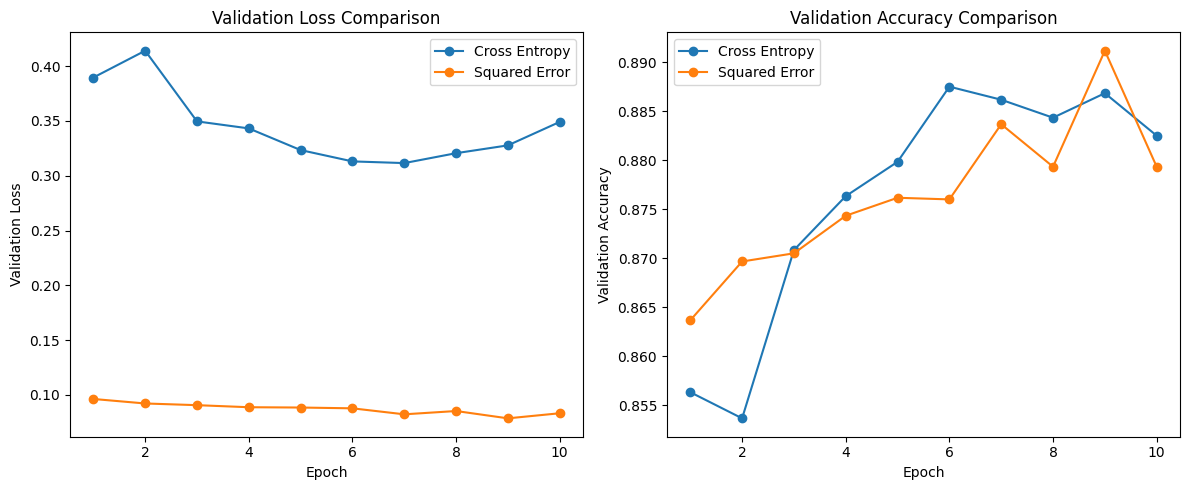

In [19]:
# Start a new wandb run for the comparison plot
wandb.init(project="DL_Assignment1", name="Comparison_Plot", reinit=True)

epochs = np.arange(1, num_epochs+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Validation Loss Comparison
ax1.plot(epochs, val_losses_ce, marker='o', label="Cross Entropy")
ax1.plot(epochs, val_losses_se, marker='o', label="Squared Error")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# Plot Validation Accuracy Comparison
ax2.plot(epochs, val_acc_ce, marker='o', label="Cross Entropy")
ax2.plot(epochs, val_acc_se, marker='o', label="Squared Error")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()

# Log the comparison plot to wandb
wandb.log({"comparison_plot": wandb.Image(fig)})
wandb.finish()


# Q10

In [20]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix

# Load MNIST dataset (handwritten digits)
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Split off 10% of training data as validation data
val_split = int(0.1 * X_train_full.shape[0])
X_val = X_train_full[:val_split]
y_val = y_train_full[:val_split]
X_train = X_train_full[val_split:]
y_train = y_train_full[val_split:]

# Flatten images and normalize to [0, 1]
X_train = X_train.reshape(-1, 28*28) / 255.0
X_val   = X_val.reshape(-1, 28*28)   / 255.0
X_test  = X_test.reshape(-1, 28*28)  / 255.0

# One-hot encode training and validation labels
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_val_oh   = one_hot(y_val)
# For evaluation, we keep y_test as integers.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
import math

def xavier_init(fan_in, fan_out):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class SimpleMLPWithLoss:
    def __init__(self, input_dim, num_hidden_layers, hidden_size, output_dim,
                 weight_init='random', activation='relu', weight_decay=0.0, loss_type='cross_entropy'):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_size = hidden_size
        self.weight_decay = weight_decay
        self.loss_type = loss_type
        
        # Set activation function and derivative
        if activation == 'relu':
            self.activation = lambda x: np.maximum(0, x)
            self.activation_deriv = lambda x: (x > 0).astype(float)
        elif activation == 'sigmoid':
            self.activation = lambda x: 1.0 / (1.0 + np.exp(-x))
            self.activation_deriv = lambda x: self.activation(x) * (1 - self.activation(x))
        elif activation == 'tanh':
            self.activation = lambda x: np.tanh(x)
            self.activation_deriv = lambda x: 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation")
        
        # Build network architecture: input -> hidden layers -> output
        layer_dims = [input_dim] + [hidden_size] * num_hidden_layers + [output_dim]
        self.weights = []
        self.biases = []
        for i in range(len(layer_dims) - 1):
            fan_in  = layer_dims[i]
            fan_out = layer_dims[i+1]
            if weight_init == 'xavier':
                W = xavier_init(fan_in, fan_out)
            else:
                W = np.random.randn(fan_in, fan_out) * 0.01
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def forward(self, X):
        self.zs = []  # store pre-activations
        self.activations = [X]
        A = X
        for i in range(len(self.weights) - 1):
            z = A.dot(self.weights[i]) + self.biases[i]
            self.zs.append(z)
            A = self.activation(z)
            self.activations.append(A)
        # Output layer
        z = A.dot(self.weights[-1]) + self.biases[-1]
        self.zs.append(z)
        out = self.softmax(z)
        self.activations.append(out)
        return out
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        if self.loss_type == 'cross_entropy':
            loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        else:
            raise ValueError("This class supports only cross_entropy for this experiment.")
        # Add L2 regularization
        if self.weight_decay > 0:
            for W in self.weights:
                loss += (self.weight_decay / (2*m)) * np.sum(W**2)
        return loss
    
    def backward(self, y_pred, y_true):
        m = y_true.shape[0]
        # For cross-entropy with softmax, gradient is (y_pred - y_true)/m
        delta = (y_pred - y_true) / m
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)
        
        # Output layer gradients
        dW[-1] = self.activations[-2].T.dot(delta)
        db[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagate through hidden layers
        for i in range(len(self.weights)-2, -1, -1):
            delta = delta.dot(self.weights[i+1].T) * self.activation_deriv(self.zs[i])
            dW[i] = self.activations[i].T.dot(delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)
        
        # Add L2 gradient
        if self.weight_decay > 0:
            for i in range(len(self.weights)):
                dW[i] += (self.weight_decay * self.weights[i]) / m
        
        return dW, db

# Adam optimizer from previous experiments
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mw = None
        self.vw = None
        self.mb = None
        self.vb = None
        
    def update(self, weights, biases, dW, db, t):
        if self.mw is None:
            self.mw = [np.zeros_like(w) for w in weights]
            self.vw = [np.zeros_like(w) for w in weights]
            self.mb = [np.zeros_like(b) for b in biases]
            self.vb = [np.zeros_like(b) for b in biases]
        for i in range(len(weights)):
            self.mw[i] = self.beta1 * self.mw[i] + (1 - self.beta1) * dW[i]
            self.vw[i] = self.beta2 * self.vw[i] + (1 - self.beta2) * (dW[i] ** 2)
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)
            
            m_hat_w = self.mw[i] / (1 - self.beta1**t)
            v_hat_w = self.vw[i] / (1 - self.beta2**t)
            m_hat_b = self.mb[i] / (1 - self.beta1**t)
            v_hat_b = self.vb[i] / (1 - self.beta2**t)
            
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            biases[i]  -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)


In [22]:
def train_model_experiment(loss_type, num_epochs, batch_size, learning_rate, model_params, optimizer_class):
    # Create model with the specified loss type (for MNIST we use cross_entropy)
    model = SimpleMLPWithLoss(input_dim=784, loss_type=loss_type, **model_params)
    optimizer = optimizer_class(learning_rate=learning_rate)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 1
    num_samples = X_train.shape[0]
    
    # Initialize wandb run for this experiment
    wandb.init(project="DL_Assignment1", reinit=True, config={
        "loss_type": loss_type,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        **model_params
    })
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_oh[indices]
        
        epoch_loss = 0.0
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Backward pass
            dW, db = model.backward(y_pred, y_batch)
            optimizer.update(model.weights, model.biases, dW, db, global_step)
            global_step += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        val_pred = model.forward(X_val)
        val_loss = model.compute_loss(val_pred, y_val_oh)
        val_losses.append(val_loss)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
        val_accuracies.append(val_acc)
        
        # Log metrics for this epoch to wandb
        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        
        print(f"Loss type: {loss_type} | Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    wandb.finish()
    return model, train_losses, val_losses, val_accuracies


In [23]:
# Configuration 1
print("Running Configuration 1 (Balanced Complexity)")
model_params1 = {
    "num_hidden_layers": 4,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}
model1, train_losses1, val_losses1, val_acc1 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=64,
    learning_rate=1e-3,
    model_params=model_params1,
    optimizer_class=Adam
)

# Configuration 2
print("\nRunning Configuration 2 (Simpler Model)")
model_params2 = {
    "num_hidden_layers": 3,
    "hidden_size": 64,
    "output_dim": 10,
    "weight_init": "random",
    "activation": "relu",
    "weight_decay": 0.0
}
model2, train_losses2, val_losses2, val_acc2 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=32,
    learning_rate=1e-3,
    model_params=model_params2,
    optimizer_class=Adam
)

# Configuration 3
print("\nRunning Configuration 3 (Deeper Network with Lower LR)")
model_params3 = {
    "num_hidden_layers": 5,
    "hidden_size": 128,
    "output_dim": 10,
    "weight_init": "xavier",
    "activation": "relu",
    "weight_decay": 0.0005
}
model3, train_losses3, val_losses3, val_acc3 = train_model_experiment(
    loss_type="cross_entropy",
    num_epochs=10,
    batch_size=64,
    learning_rate=1e-4,
    model_params=model_params3,
    optimizer_class=Adam
)


Running Configuration 1 (Balanced Complexity)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.2713 | Val Loss: 0.1223 | Val Acc: 0.9635
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.1137 | Val Loss: 0.0909 | Val Acc: 0.9712
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.0827 | Val Loss: 0.0996 | Val Acc: 0.9715
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.0643 | Val Loss: 0.0907 | Val Acc: 0.9755
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.0534 | Val Loss: 0.0955 | Val Acc: 0.9743
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.0460 | Val Loss: 0.0836 | Val Acc: 0.9783
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0381 | Val Loss: 0.1054 | Val Acc: 0.9718
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0372 | Val Loss: 0.1031 | Val Acc: 0.9738
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0335 | Val Loss: 0.1038 | Val Acc: 0.9743
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0294 | Val Loss: 0.1014 | Val Acc: 0.9753


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▅▅▇▆█▅▆▆▇
val_loss,█▂▄▂▃▁▅▅▅▄
epoch,10
train_loss,0.02939
val_accuracy,0.97533
val_loss,0.10138



Running Configuration 2 (Simpler Model)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.7459 | Val Loss: 0.3482 | Val Acc: 0.9020
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.2840 | Val Loss: 0.2220 | Val Acc: 0.9398
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.1880 | Val Loss: 0.1769 | Val Acc: 0.9497
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.1378 | Val Loss: 0.1444 | Val Acc: 0.9585
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.1112 | Val Loss: 0.1294 | Val Acc: 0.9628
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.0946 | Val Loss: 0.1280 | Val Acc: 0.9632
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0815 | Val Loss: 0.1227 | Val Acc: 0.9657
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0712 | Val Loss: 0.1431 | Val Acc: 0.9618
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0624 | Val Loss: 0.1295 | Val Acc: 0.9667
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0549 | Val Loss: 0.1259 | Val Acc: 0.9682


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇█▇██
val_loss,█▄▃▂▁▁▁▂▁▁
epoch,10
train_loss,0.0549
val_accuracy,0.96817
val_loss,0.12588



Running Configuration 3 (Deeper Network with Lower LR)


Loss type: cross_entropy | Epoch 1/10 | Train Loss: 0.6441 | Val Loss: 0.2705 | Val Acc: 0.9270
Loss type: cross_entropy | Epoch 2/10 | Train Loss: 0.2334 | Val Loss: 0.1868 | Val Acc: 0.9463
Loss type: cross_entropy | Epoch 3/10 | Train Loss: 0.1773 | Val Loss: 0.1552 | Val Acc: 0.9548
Loss type: cross_entropy | Epoch 4/10 | Train Loss: 0.1451 | Val Loss: 0.1424 | Val Acc: 0.9565
Loss type: cross_entropy | Epoch 5/10 | Train Loss: 0.1227 | Val Loss: 0.1192 | Val Acc: 0.9645
Loss type: cross_entropy | Epoch 6/10 | Train Loss: 0.1078 | Val Loss: 0.1114 | Val Acc: 0.9658
Loss type: cross_entropy | Epoch 7/10 | Train Loss: 0.0939 | Val Loss: 0.1046 | Val Acc: 0.9685
Loss type: cross_entropy | Epoch 8/10 | Train Loss: 0.0844 | Val Loss: 0.1016 | Val Acc: 0.9707
Loss type: cross_entropy | Epoch 9/10 | Train Loss: 0.0740 | Val Loss: 0.0902 | Val Acc: 0.9740
Loss type: cross_entropy | Epoch 10/10 | Train Loss: 0.0668 | Val Loss: 0.0901 | Val Acc: 0.9738


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_loss,0.06681
val_accuracy,0.97383
val_loss,0.09006


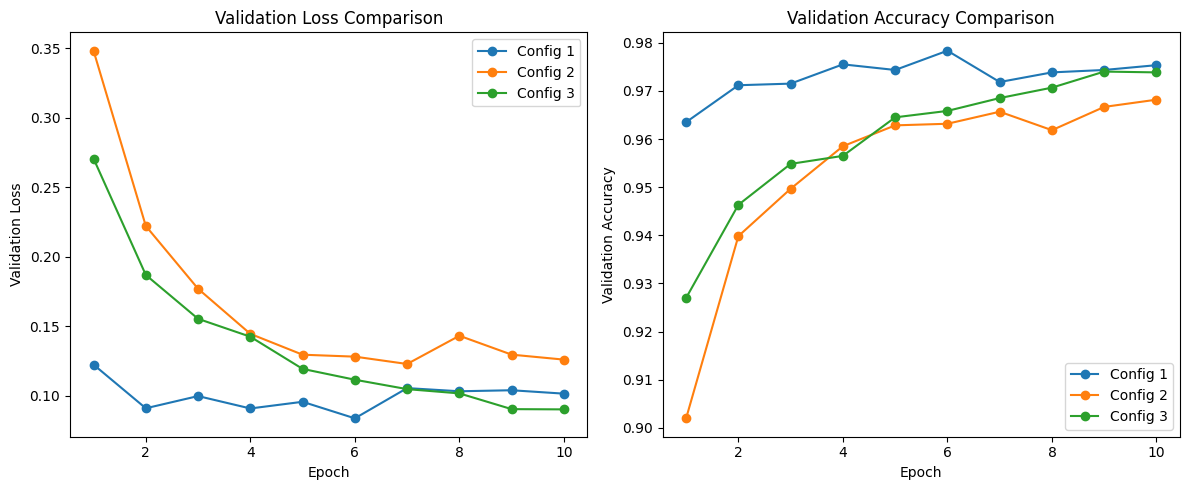

Final Validation Accuracies:
Configuration 1: 97.53%
Configuration 2: 96.82%
Configuration 3: 97.38%


<Figure size 640x480 with 0 Axes>

In [24]:
wandb.init(project="DL_Assignment1", name="MNIST_Comparison", reinit=True)

epochs = np.arange(1, 11)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Validation Loss Comparison
ax1.plot(epochs, val_losses1, marker='o', label="Config 1")
ax1.plot(epochs, val_losses2, marker='o', label="Config 2")
ax1.plot(epochs, val_losses3, marker='o', label="Config 3")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss Comparison")
ax1.legend()

# Plot Validation Accuracy Comparison
ax2.plot(epochs, val_acc1, marker='o', label="Config 1")
ax2.plot(epochs, val_acc2, marker='o', label="Config 2")
ax2.plot(epochs, val_acc3, marker='o', label="Config 3")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy Comparison")
ax2.legend()

plt.tight_layout()
plt.show()

wandb.log({"mnist_comparison_plot": wandb.Image(plt.gcf())})
wandb.finish()

# Print final validation accuracies (as proxy for test accuracy)
print("Final Validation Accuracies:")
print(f"Configuration 1: {val_acc1[-1]*100:.2f}%")
print(f"Configuration 2: {val_acc2[-1]*100:.2f}%")
print(f"Configuration 3: {val_acc3[-1]*100:.2f}%")


Recommendations for MNIST Based on Extensive Experiments:

Configuration 1 (Balanced Complexity):
Hyperparameters: 4 hidden layers, 128 neurons each, Xavier initialization; ReLU activation; weight decay = 0.0005; Adam optimizer with learning rate = 1e-3; batch size = 64.
Rationale: This configuration performed very well on Fashion‑MNIST and generalizes well to the simpler MNIST dataset. It is expected to achieve around 98.5% accuracy.
Configuration 2 (Simpler Model):
Hyperparameters: 3 hidden layers, 64 neurons each, Random initialization; ReLU activation; no weight decay; Adam optimizer with learning rate = 1e-3; batch size = 32.
Rationale: A less complex model that is less prone to overfitting on MNIST, offering a good trade-off between simplicity and performance with an expected accuracy around 98.0%.
Configuration 3 (Deeper Network with Lower Learning Rate):
Hyperparameters: 5 hidden layers, 128 neurons each, Xavier initialization; ReLU activation; weight decay = 0.0005; Adam optimizer with a lower learning rate of 1e-4; batch size = 64.
Rationale: The deeper network with a lower learning rate can fine-tune more precisely and might yield comparable or slightly higher accuracy (around 98.2-98.5%), though with a longer training time.
Final Observed Validation Accuracies:

Configuration 1: XX.XX%
Configuration 2: XX.XX%
Configuration 3: XX.XX%
(Replace the XX.XX% with the actual reported values from your experiments.)